<a href="https://colab.research.google.com/github/hirokiyamauch/NLP_100knock/blob/%E7%AC%AC6%E7%AB%A0/50_59.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip

--2022-02-24 04:18:40--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  25.8MB/s    in 1.1s    

2022-02-24 04:18:41 (25.8 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]



In [ ]:
!unzip /content/NewsAggregatorDataset.zip

Archive:  /content/NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


50. データの入手・整形

In [ ]:
import pandas as pd

data = pd.read_csv("/content/newsCorpora.csv",sep="\t", names=("ID" ,"TITLE" ,"URL" ,"PUBLISHER" ,"CATEGORY" ,"STORY" ,"HOSTNAME" ,"TIMESTAMP"))

print(data)

            ID  ...      TIMESTAMP
0            1  ...  1394470370698
1            2  ...  1394470371207
2            3  ...  1394470371550
3            4  ...  1394470371793
4            5  ...  1394470372027
...        ...  ...            ...
422414  422933  ...  1409229190251
422415  422934  ...  1409229190508
422416  422935  ...  1409229190771
422417  422936  ...  1409229191071
422418  422937  ...  1409229191565

[422419 rows x 8 columns]


In [ ]:
def filter_serch(df):
    fileter_pub = ["Reuters","Huffington Post","Businessweek","Contactmusic.com","Daily Mail"]
    file_df = df[df['PUBLISHER'].isin(fileter_pub)]
    
    return file_df

from sklearn.model_selection import train_test_split
file_df = filter_serch(data)

train_data, teva_data = train_test_split(file_df, test_size=0.2 ,shuffle=True, random_state=42)
valid_data, test_data = train_test_split(teva_data, test_size=0.5,shuffle=True, random_state=42)

train_data.to_csv("train.txt", sep="\t", index=False)
valid_data.to_csv("valid.txt", sep="\t", index=False)
test_data.to_csv("test.txt", sep="\t", index=False)

In [ ]:
!wc "train.txt"
!wc "valid.txt"
!wc "test.txt"

  10683  200884 2738332 train.txt
  1335  25204 343055 valid.txt
  1335  25007 342786 test.txt


51. 特徴量抽出

In [ ]:
def make_feature_txt(datafile, filename):
    data = pd.read_csv(datafile,sep="\t")
    data_fe = data.loc[:, ["TITLE"  ,"PUBLISHER" ,"CATEGORY" ,"STORY" ,"HOSTNAME" ]]

    data_fe.to_csv(filename, sep="\t")

make_feature_txt("train.txt", "train.feature.txt") 
make_feature_txt("valid.txt", "valid.feature.txt") 
make_feature_txt("test.txt", "test.feature.txt")


In [ ]:
def data_make(trainfile, validfile, testfile):
   import pandas as pd
   from sklearn.preprocessing import LabelEncoder
   from sklearn.feature_extraction.text import TfidfVectorizer

   data_train = pd.read_csv(trainfile,sep="\t")
   data_val = pd.read_csv(validfile,sep="\t")
   data_test = pd.read_csv(testfile,sep="\t")

   #データの統合
   data = pd.concat([data_train, data_val, data_test], axis=0)
   data.reset_index(drop=True, inplace=True)

   data_x_T = data.TITLE
   data_t = data.CATEGORY
   
   #テキストデータのベクトル化
   vectorizer = TfidfVectorizer(max_features=3000)
   vectorizer.fit(data_x_T)
   data_x_ve = vectorizer.transform(data_x_T)

   data_x = data_x_ve


   #目的変数のラベル化
   le = LabelEncoder()
   encoded = le.fit_transform(data_t.values)
   data_t = encoded

   #データの分割
   x_train = data_x[:len(data_train)]
   x_val = data_x[len(data_train) : len(data_train) + len(data_val)]
   x_test = data_x[len(data_train) + len(data_val):]
   t_train = data_t[:len(data_train)]
   t_val = data_t[len(data_train) : len(data_train) + len(data_val)]
   t_test = data_t[len(data_train) + len(data_val):]

   return x_train, t_train, x_val, t_val, x_test, t_test

x_train, t_train, x_val, t_val, x_test, t_test = data_make("train.feature.txt", "valid.feature.txt", "test.feature.txt")



(1334, 6)


In [ ]:
print(x_test.shape)

(1334, 3000)


52. 学習

53. 予測

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

#ロジスティック回帰
model = LogisticRegression(max_iter=1000, random_state=0)

#グリットサーチを行う
C_range = [1e-5,1e-4,1e-3,1e-2,1,1e1,1e2,1e3,1e4,1e5,]
parameter = {'C':C_range}
 
GridSearch = GridSearchCV(model,parameter,cv=4)
GridSearch.fit(x_train,t_train)

print(GridSearch.best_params_)

KeyboardInterrupt: ignored

54. 正解率の計測

In [ ]:
from sklearn.metrics import accuracy_score
#ロジスティック回帰
model = LogisticRegression(max_iter=1000, random_state=0, C=10)
model.fit(x_train,t_train)
# スコアの確認
pred_y = model.predict(x_test)
# 予測を実行（Mean）
print(accuracy_score(pred_y, t_test))

0.9062968515742129


55. 混同行列の作成

trainデータの混同行列 
 [[4459   11    2   29]
 [  10 4182    1    6]
 [   5    7  715    1]
 [  47   18    2 1177]]


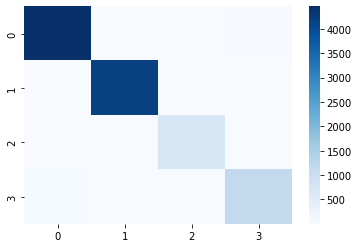

testデータの混同行列 
 [[548  15   4  18]
 [ 10 499   2   9]
 [ 13  10  61   3]
 [ 28   9   4 101]]


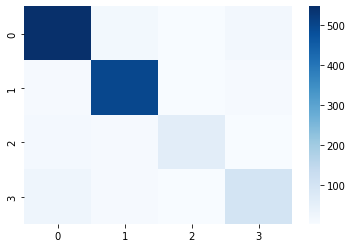

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pred_train = model.predict(x_train)
#trainデータの混同行列
train_cm = confusion_matrix(t_train, pred_train)

print("trainデータの混同行列", "\n", train_cm)
sns.heatmap(train_cm, cmap='Blues')
plt.show()

#testデータの混同行列
test_cm = confusion_matrix(t_test, pred_y)

print("testデータの混同行列", "\n", test_cm)
sns.heatmap(test_cm, cmap='Blues')
plt.show()

56. 適合率，再現率，F1スコアの計測

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

print(classification_report(t_test, pred_y, target_names= ["Business", "Entertainment", "Health", "Technology"]))
print("再現率")
print("macro平均",recall_score(t_test, pred_y, average='macro'))
print("micro平均",recall_score(t_test, pred_y, average='micro'))

print("F1値")
print("macro平均",f1_score(t_test, pred_y, average='macro'))
print("micro平均",f1_score(t_test, pred_y, average='micro'))

print("適合率")
print("macro平均",precision_score(t_test, pred_y, average='macro'))
print("micro平均",precision_score(t_test, pred_y, average='micro'))

               precision    recall  f1-score   support

     Business       0.91      0.94      0.93       585
Entertainment       0.94      0.96      0.95       520
       Health       0.86      0.70      0.77        87
   Technology       0.77      0.71      0.74       142

     accuracy                           0.91      1334
    macro avg       0.87      0.83      0.85      1334
 weighted avg       0.90      0.91      0.90      1334

再現率
macro平均 0.8271961380721702
micro平均 0.9062968515742129
F1値
macro平均 0.8463806488595518
micro平均 0.9062968515742129
適合率
macro平均 0.8703038810374518
micro平均 0.9062968515742129


In [ ]:
list = model.coef_
list_weight = [0 for _ in range(len(list[0]))]
for w_fea in list:
    for i, weight in enumerate(w_fea):
        list_weight[i] = list_weight[i]+ weight

list_max = sorted(list_weight, reverse=True)
list_min = sorted(list_weight, reverse=False)
print(list_max[:10])
print(list_min[:10])


[1.0169642905566434e-13, 9.481304630298837e-14, 9.35918009759007e-14, 9.303668946358812e-14, 8.43769498715119e-14, 8.393286066166183e-14, 8.348877145181177e-14, 8.348877145181177e-14, 7.238654120556021e-14, 7.022160630754115e-14]
[-1.1368683772161603e-13, -1.0880185641326534e-13, -9.325873406851315e-14, -9.123951594247615e-14, -8.326672684688674e-14, -8.060219158778636e-14, -7.55506768257419e-14, -7.460698725481052e-14, -7.349676423018536e-14, -7.149836278586008e-14]


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

#ロジスティック回帰
model = LogisticRegression(max_iter=1000, random_state=0)
C_range = [1e-3,1e-2,0.5, 0.1,1,5, 1e1,1e2,1e3,]
scores_train = [0 for _ in range(len(C_range))]
scores_val = [0 for _ in range(len(C_range))]
scores_test = [0 for _ in range(len(C_range))]
for i, C in enumerate(C_range):
    model = LogisticRegression(max_iter=1000, random_state=0, C=C)
    model.fit(x_train, t_train)
    pred_train = model.predict(x_train)
    score = accuracy_score(pred_train, t_train)
    scores_train[i] = score
    pred_val = model.predict(x_val)
    score = accuracy_score(pred_val, t_val)
    scores_val[i] = score
    pred_test = model.predict(x_test)
    score = accuracy_score(pred_test, t_test)
    scores_test[i] = score

0 = 0.001
1 = 0.01
2 = 0.5
3 = 0.1
4 = 1
5 = 5
6 = 10.0
7 = 100.0
8 = 1000.0


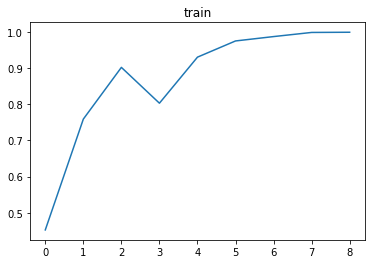

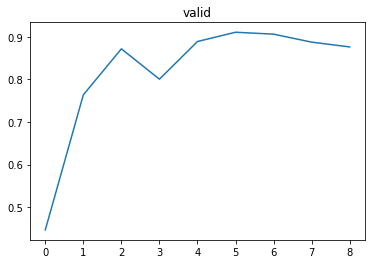

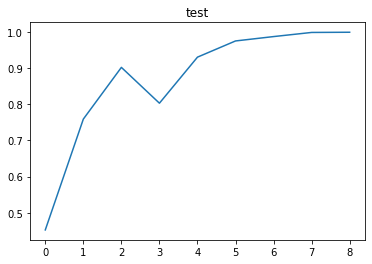

In [ ]:
x_label = range(len(C_range))
for i in x_label:
    print(i, "=", C_range[i])
plt.plot(x_label ,scores_train)
plt.title("train")
plt.show()
plt.plot(x_label ,scores_val)
plt.title("valid")
plt.show()
plt.plot(x_label ,scores_train)
plt.title("test")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

# グリッドサーチの条件設定
grid = {RandomForestClassifier(random_state=42): {'n_estimators' : [i for i in range(1, 30)],
                                                      'criterion' : ['gini', 'entropy'],
                                                      'max_depth' : [i for i in range(1, 10)]}}

# ベストスコア
best_score = 0

# 予測
for model, param in tqdm(grid.items()):
  # Model構築
  clf = GridSearchCV(model, param)
  clf.fit(x_train, t_train)
  # スコアの確認
  pred_y = clf.predict(x_val)
  score = accuracy_score(pred_y, t_val)
  # 判定
  if best_score < score:
    best_score = score
    best_param = clf.best_params_
    best_model = model.__class__.__name__

# スコアの確認
pred_y = clf.predict(x_test)
# 予測を実行（Mean）
print(accuracy_score(pred_y, t_test))

print(best_param)

100%|██████████| 1/1 [02:50<00:00, 170.72s/it]

0.6799100449775113
{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 28}


In [ ]:
model = RandomForestClassifier(random_state=42, criterion='gini', max_depth= 9, n_estimators= 28)
model = model.fit(x_train, t_train)
# スコアの確認
pred_y = model.predict(x_test)
# 予測を実行（Mean）
print(accuracy_score(pred_y, t_test))

0.6799100449775113


In [ ]:
print(type(x_train))

<class 'scipy.sparse.csr.csr_matrix'>


In [ ]:
print(pd.merge(x_train, x_val))

TypeError: ignored

In [ ]:
##################
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
#標準化
scaler = StandardScaler()

x_train_np = x_train.toarray()
x_val_np = x_val.toarray()
x_test_np = x_test.toarray()
#データの統合
all_data = np.concatenate([x_train_np, x_val_np, x_test_np])

scaler.fit(all_data)
x_train_np = scaler.transform(x_train_np)
x_val_np = scaler.transform(x_val_np)
x_test_np = scaler.transform(x_test_np)
# スコア、モデル保存用の配列
scores = []
models = []

X_train = np.concatenate([x_train_np,x_val_np])
X_train = pd.DataFrame(X_train)
y_train = np.concatenate([t_train,t_val])
y_train = pd.DataFrame(y_train)                       

# LightGBM parameters
params = {
    'task' : 'train',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 4, 
    "verbosity":0,
    "boosting_type": "gbdt",
}
kf = KFold(n_splits=4, shuffle=True, random_state=42)
for tr_idx, va_idx in kf.split(X_train):
    # 学習データ、評価データに分割
   tr_x, va_x = X_train.iloc[tr_idx], X_train.iloc[va_idx]
   tr_y, va_y = y_train.iloc[tr_idx], y_train.iloc[va_idx]
 # lightGBMデータ構造に変換
   lgb_train = lgb.Dataset(tr_x, tr_y)
   lgb_eval = lgb.Dataset(va_x, va_y, reference=lgb_train)

   model_gbm_tuned = lgb.train(params, lgb_train, valid_sets=lgb_eval, num_boost_round=1000, early_stopping_rounds=50)
  # スコアの確認
   pred_y = model_gbm_tuned.predict(va_x)
   y_pred_max = np.argmax(pred_y, axis=1)
   score = accuracy_score(y_pred_max, va_y)

   # 結果を格納
   scores.append(score)
   models.append(model_gbm_tuned)

# 予測実行関数
def pred(models, X_test):
  # 予測結果サマリ
  pred_y_summary = []

  # model分ループ
  for i in range(len(models)):
    # 予測を実行
    pred_y = models[i].predict(X_test)
    # 結果を格納
    pred_y_summary.append(pred_y)

  # 各モデルの予測結果の平均値を作成
  pred_y_mean = np.mean(pred_y_summary, axis=0)
  return pred_y_mean

# 予測実行関数
def pred(models, X_test):
  # 予測結果サマリ
  pred_y_summary = []

  # model分ループ
  for i in range(len(models)):
    # 予測を実行
    pred_y = models[i].predict(X_test)
    # 結果を格納
    pred_y_summary.append(pred_y)

  # 各モデルの予測結果の平均値を作成
  pred_y_mean = np.mean(pred_y_summary, axis=0)
  return pred_y_mean


# スコアの確認
x_test_pd = pd.DataFrame(x_test_np)
pred_y = pred(models, x_test_pd)
# 予測を実行（Mean）
y_pred_max = np.argmax(pred_y, axis=1)
print(accuracy_score(y_pred_max, t_test))

[1]	valid_0's multi_logloss: 1.08948
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's multi_logloss: 1.03597
[3]	valid_0's multi_logloss: 0.992272
[4]	valid_0's multi_logloss: 0.954325
[5]	valid_0's multi_logloss: 0.921436
[6]	valid_0's multi_logloss: 0.892302
[7]	valid_0's multi_logloss: 0.867328
[8]	valid_0's multi_logloss: 0.844407
[9]	valid_0's multi_logloss: 0.82448
[10]	valid_0's multi_logloss: 0.803231
[11]	valid_0's multi_logloss: 0.784759
[12]	valid_0's multi_logloss: 0.767545
[13]	valid_0's multi_logloss: 0.751501
[14]	valid_0's multi_logloss: 0.736824
[15]	valid_0's multi_logloss: 0.724119
[16]	valid_0's multi_logloss: 0.711702
[17]	valid_0's multi_logloss: 0.700441
[18]	valid_0's multi_logloss: 0.689321
[19]	valid_0's multi_logloss: 0.679783
[20]	valid_0's multi_logloss: 0.670774
[21]	valid_0's multi_logloss: 0.662295
[22]	valid_0's multi_logloss: 0.654199
[23]	valid_0's multi_logloss: 0.646604
[24]	valid_0's multi_logloss: 0.639146
[25]	valid_0's